# Virtual staining of phase contrast images using VSCyto3D with and without augmentations

Written by Eduardo Hirata-Miyasaki, Ziwen Liu, and Shalin Mehta, CZ Biohub San Francisco

## Overview

This notebook demonstrates how to use the VSCyto3D model to virtually stain phase contrast images. The phase contrast images were not part of the training.
We will use the VSCyto3D model to predict the nuclei and cell membrane channels from a phase contrast image with two models:
- One model trained without augmentations
- One model trained with augmentations


In [1]:
# Imports
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from iohub import open_ome_zarr
from lightning.pytorch import seed_everything

from viscy.data.hcs import HCSDataModule
from viscy.trainer import VisCyTrainer
from viscy.transforms import NormalizeSampled

# Viscy classes for the trainer and model
from viscy.translation.engine import VSUNet

# seed random number generators for reproducibility.
seed_everything(42, workers=True)

/hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


42

In [2]:
# Paths to data and log directory
top_dir = Path(
    "~/data/vs_PhC"
).expanduser()  # If this fails, make sure this to point to your data directory in the shared mounting point inside /dlmbl/data

# Path to the training data
data_path = top_dir / "test/HEK_H2B_CAAX_PhC_40x_registered.zarr"

## Load OME-Zarr Dataset

There should be 34 FOVs in the dataset.

Each FOV consists of 3 channels of 2048x2048 images,
saved in the [High-Content Screening (HCS) layout](https://ngff.openmicroscopy.org/latest/#hcs-layout)
specified by the Open Microscopy Environment Next Generation File Format
(OME-NGFF).

The 3 channels correspond to the QPI, nuclei, and cell membrane. The nuclei were stained with DAPI and the cell membrane with Cellmask.

- The layout on the disk is: `row/col/field/pyramid_level/timepoint/channel/z/y/x.`
- These datasets only have 1 level in the pyramid (highest resolution) which is '0'.

In [3]:
# Open dataset and look at it's structure
dataset = open_ome_zarr(data_path)
dataset.print_tree()

/
 └── 0
     └── 3
         ├── 000000
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 000001
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 000002
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 000003
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 001000
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 001001
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 001002
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 001003
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 002000
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 002001
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 002002
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 002003
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 003000
         │   └── 0 (3, 3, 50, 2044, 2005) float32
         ├── 003001
         │   └── 0 (3, 3, 50, 2044, 2005) float32


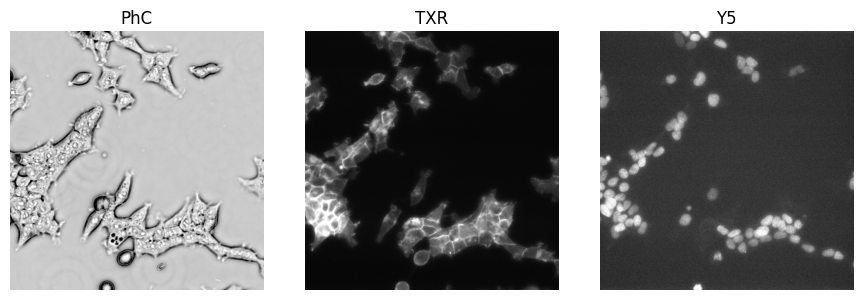

In [4]:
row = 0
col = 3
field = "000000"  # TODO Change this for a different FOV

# NOTE: this dataset only has one level
pyaramid_level = 0

fov_path = f"{row}/{col}/{field}"
input_data_path = Path(data_path) / fov_path
image = dataset[fov_path][pyaramid_level].numpy()

n_channels = len(dataset.channel_names)
Z, Y, X = image.shape[-3:]
figure, axes = plt.subplots(1, n_channels, figsize=(9, 3))
title_names = ["PhC", "TXR", "Y5"]
for i in range(n_channels):
    for i in range(n_channels):
        channel_image = image[0, i, Z // 2]
        # Invert the phase contrast channel
        if i == 0:
            channel_image = channel_image * -1
        # Adjust contrast to 0.5th and 99.5th percentile of pixel values.
        p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
        channel_image = np.clip(channel_image, p_low, p_high)
        axes[i].imshow(channel_image, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(title_names[i])
plt.tight_layout()

## Create the VSCyto3D model
Here we will instantiate the `HCSDataModule` that reads the ome-zarr dataset and prepares the data for inference.

In [5]:
# Reduce the batch size if encountering out-of-memory errors
BATCH_SIZE = 5
# NOTE: Set the number of workers to 0 for Windows and macOS
# since multiprocessing only works with a
# `if __name__ == '__main__':` guard.
# On Linux, set it to the number of CPU cores to maximize performance.
NUM_WORKERS = 0
source_channel_name = "BF"

# %%[markdown]
"""
For this example we will use the following parameters:
### For more information on the VSCyto3D model:
See ``viscy.unet.networks.fcmae``
([source code](https://github.com/mehta-lab/VisCy/blob/6a3457ec8f43ecdc51b1760092f1a678ed73244d/viscy/unet/networks/unext2.py#L252))
for configuration details.
"""

'\nFor this example we will use the following parameters:\n### For more information on the VSCyto3D model:\nSee ``viscy.unet.networks.fcmae``\n([source code](https://github.com/mehta-lab/VisCy/blob/6a3457ec8f43ecdc51b1760092f1a678ed73244d/viscy/unet/networks/unext2.py#L252))\nfor configuration details.\n'

In [6]:
# Setup the data module.
data_module = HCSDataModule(
    data_path=input_data_path,
    source_channel=source_channel_name,
    target_channel=["Nuclei", "Membrane"],
    z_window_size=5,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    architecture="UNeXt2",
    normalizations=[
        NormalizeSampled(
            [source_channel_name],
            level="fov_statistics",
            subtrahend="median",
            divisor="iqr",
        )
    ],
)
data_module.prepare_data()
data_module.setup(stage="predict")

## Setup the _VSCyto3D_ model with and without augmentations
We will load the model checkpoints and run inference on the phase contrast image.abs
The model that utilizes augmentations shows better performance in the prediction of the nuclei and cell membrane channels.
The phase contrast images were not part of the training for the `VSCyto3D`` model.

/hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


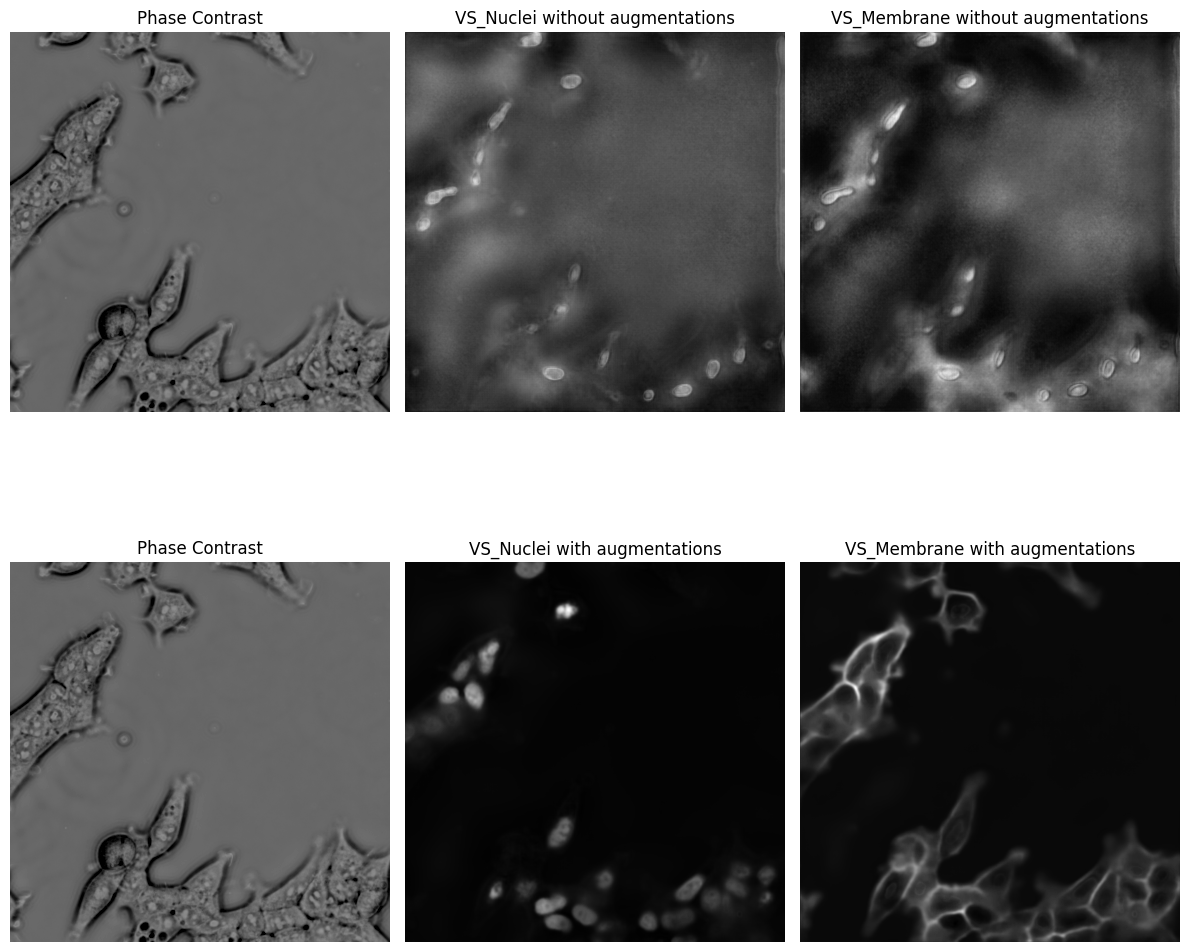

In [7]:
# TODO: change if you want to use a different GPU
GPU_ID = 0

# TODO: point to the downloaded model checkpoints
no_augmentation_model_ckpt = (
    top_dir / "models/no_augmentations/best_epoch=30-step=6076.ckpt"
)
VSCyto3D_model_ckpt = top_dir / "models/epoch=48-step=18130.ckpt"

# Dictionary that specifies key parameters of the model.
config_VSCyto3D = {
    "in_channels": 1,
    "out_channels": 2,
    "in_stack_depth": 5,
    "backbone": "convnextv2_tiny",
    "stem_kernel_size": (5, 4, 4),
    "decoder_mode": "pixelshuffle",
    "head_expansion_ratio": 4,
    "head_pool": True,
}

# Model without augmentation
model_VSCyto3D_no_augmentation = VSUNet.load_from_checkpoint(
    no_augmentation_model_ckpt, architecture="UNeXt2", model_config=config_VSCyto3D
)
model_VSCyto3D_no_augmentation.eval()
# Model with augmentation
model_VSCyto3D_w_augmentation = VSUNet.load_from_checkpoint(
    VSCyto3D_model_ckpt, architecture="UNeXt2", model_config=config_VSCyto3D
)
model_VSCyto3D_w_augmentation.eval()

# Setup the Trainer
trainer = VisCyTrainer(accelerator="gpu", devices=[GPU_ID], precision="16-mixed")

n = 5
patch_size = 256
y_slice = slice(Y // 2 - patch_size * n // 2, Y // 2 + patch_size * n // 2)
x_slice = slice(X // 2 - patch_size * n // 2, X // 2 + patch_size * n // 2)

# Get the Phase Contrast channel
c_idx = dataset.channel_names.index(source_channel_name)
phase_image = image[0:1, c_idx : c_idx + 1, Z // 2 - 3 : Z // 2 + 3, y_slice, x_slice]
# Normalize the image
median = dataset[fov_path].zattrs["normalization"][source_channel_name][
    "fov_statistics"
]["median"]
iqr = dataset[fov_path].zattrs["normalization"][source_channel_name]["fov_statistics"][
    "iqr"
]
phase_image = ((phase_image - median) / iqr) * -1

# Load the image to device
device = model_VSCyto3D_no_augmentation.device
phase_image = torch.tensor(phase_image).to(device)

# Run inference on the given volume
with torch.inference_mode():  # turn off gradient computation.
    pred_no_augmentation = model_VSCyto3D_no_augmentation(phase_image)
    pred_w_augmentation = model_VSCyto3D_w_augmentation(phase_image)

pred_no_augmentation = pred_no_augmentation.cpu().detach().numpy()
pred_w_augmentation = pred_w_augmentation.cpu().detach().numpy()
phase_image = phase_image.cpu().detach().numpy()
clim_max = 30
clim_min = -20

# Plot the predicted images with model without augmentations
fig, ax = plt.subplots(2, 3, figsize=(12, 12))
ax[0, 0].imshow(phase_image[0, 0, 2, :, :], cmap="gray", vmin=clim_min, vmax=clim_max)
ax[0, 0].axis("off")
ax[0, 0].set_title("Phase Contrast")
for i in range(2):
    ax[0, i + 1].imshow(pred_no_augmentation[0, i, 2, :, :], cmap="gray")
    ax[0, i + 1].axis("off")
ax[0, 1].set_title("VS_Nuclei without augmentations")
ax[0, 2].set_title("VS_Membrane without augmentations")

# Plot the predicted images with VSCyto3D with augmentations
ax[1, 0].imshow(phase_image[0, 0, 2, :, :], cmap="gray", vmin=clim_min, vmax=clim_max)
ax[1, 0].axis("off")
ax[1, 0].set_title("Phase Contrast")
for i in range(2):
    ax[1, i + 1].imshow(
        pred_w_augmentation[0, i, 2, :, :],
        cmap="gray",
    )
    ax[1, i + 1].axis("off")
ax[1, 1].set_title("VS_Nuclei with augmentations")
ax[1, 2].set_title("VS_Membrane with augmentations")

plt.tight_layout()